In [74]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
def prep_features(csv_file="data/train.csv"):
    df= pd.read_csv(csv_file, index_col=0)
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['FamSize'] = df['Parch'] + df['SibSp']

    decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
    deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
    title_dummies = pd.get_dummies(df['Title'])
    gender_dummies = pd.get_dummies(df['Sex'])
    class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')
    embarked_dummies = pd.get_dummies(df['Embarked'])
    has_age = df['Age'].notnull().astype('int')
    has_age.name = 'has_age'

    # saving to variables and using .concat() once seems to be much faster
    df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies, 
                    embarked_dummies, has_age], axis=1)

In [195]:
df = pd.read_csv("data/train.csv", index_col=0)

df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamSize'] = df['Parch'] + df['SibSp']

decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
title_dummies = pd.get_dummies(df['Title'])
gender_dummies = pd.get_dummies(df['Sex'])
class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')
embarked_dummies = pd.get_dummies(df['Embarked'])
has_age = df['Age'].notnull().astype('int')
has_age.name = 'has_age'

# saving to variables and using .concat() once seems to be much faster
df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies, 
                embarked_dummies, has_age], axis=1)

### Use Ridge regression to impute ages

In [196]:
X_train_age = df[df['Age'].notnull()][df.corr().columns]
X_needs_age = df[df['Age'].isnull()][df.corr().columns]
y_train_age = X_train_age.pop('Age')
X_needs_age = X_needs_age.drop('Age', axis=1)
ridge_age = RidgeCV()

X_train_age['Fare'].fillna(value=X_train_age['Fare'].mean(), inplace=True)

ridge_age.fit(X_train_age, y_train_age)
age_pred = np.array(ridge_age.predict(X_needs_age))

age_pred[age_pred < 0] =0

df.loc[df['Age'].isnull(), ('Age')] = age_pred

In [78]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(array([  57.,   40.,  189.,  258.,  160.,   95.,   53.,   26.,   11.,    2.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.]),
 <a list of 10 Patch objects>)

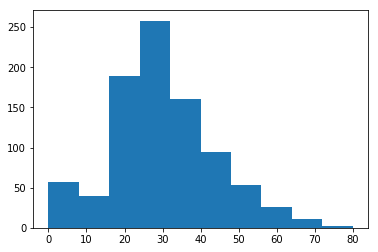

In [79]:
plt.hist(df['Age'])

In [80]:
has_age.sum()

714

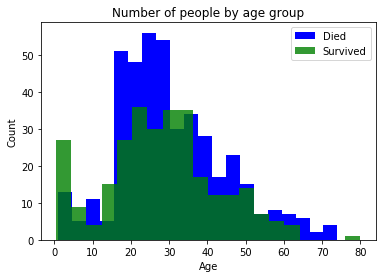

In [81]:
plt.hist(df[(df['Survived'] == 0) & (df['has_age'] == 1)]['Age'], color='b', label='Died', bins=20)
plt.hist(df[(df['Survived'] == 1) & (df['has_age'] == 1)]['Age'], color='g', alpha=0.8, label='Survived', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Number of people by age group')
plt.legend()
plt.show()

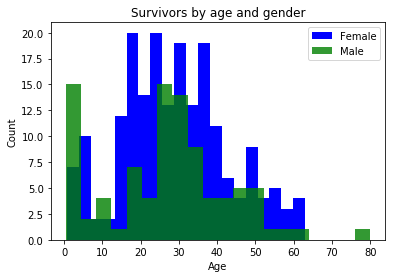

In [82]:
male_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['male'] == 1)]['Age']
female_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['female'] == 1)]['Age']

plt.hist(female_survivor_ages, color='b', label='Female', bins=20)
plt.hist(male_survivor_ages, color='g', label='Male', bins=20, alpha=.8)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Survivors by age and gender')
plt.legend()
plt.show()

### Logistic Regression (no feature engineering)

In [83]:
X_min = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y_min = X_min.pop('Survived')

In [84]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.670018,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.678426,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.359090,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [85]:
X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(X_min, y_min)

logreg_min = LogisticRegressionCV(n_jobs=-1)

logreg_min.fit(X_train_minimal, y_train_minimal)

y_pred = logreg_min.predict(X_test_minimal)

cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[129  10]
 [ 51  33]]


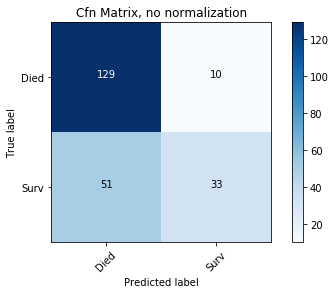

In [86]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.61  0.39]]


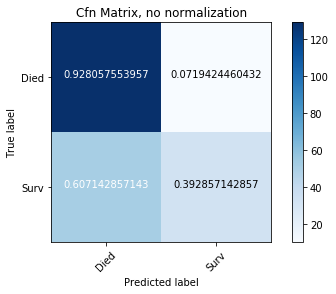

In [87]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [88]:
print(classification_report(y_test_minimal, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.72      0.93      0.81       139
       Surv       0.77      0.39      0.52        84

avg / total       0.74      0.73      0.70       223



In [89]:
logreg_min.score(X_test_minimal,y_test_minimal)

0.726457399103139

In [90]:
logreg_min.score(X_min,y_min)

0.72390572390572394

In [91]:
precision_score(y_test_minimal, y_pred)

0.76744186046511631

In [92]:
recall_score(y_test_minimal, y_pred)

0.39285714285714285

### Logistic Regression (with added features)

In [107]:
X = df[df.corr().columns]
y = X.pop('Survived')

In [108]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,...,the Countess,female,male,Class_1,Class_2,Class_3,C,Q,S,has_age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.00000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.670018,0.523008,0.381594,32.204208,0.904602,0.016835,0.052750,0.066218,0.03367,...,0.001122,0.352413,0.647587,0.242424,0.206510,0.551066,0.188552,0.086420,0.722783,0.801347
std,0.836071,13.678426,1.102743,0.806057,49.693429,1.613459,0.128725,0.223659,0.248802,0.18048,...,0.033501,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.447876,0.399210
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,29.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,36.359090,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_features, y_train_features)

y_pred = logreg.predict(X_test_features)

cfn_matrix_features = confusion_matrix(y_test_features, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[109  23]
 [ 17  74]]


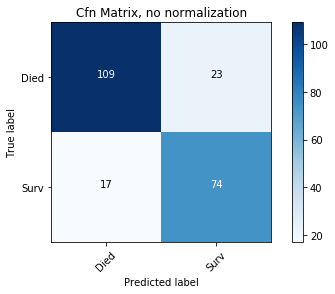

In [112]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.24  0.76]]


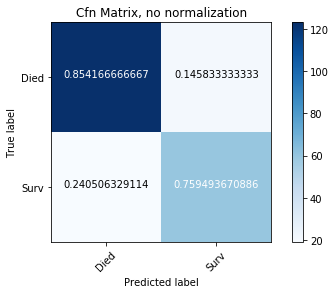

In [99]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [100]:
print(classification_report(y_test_features, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.87      0.85      0.86       144
       Surv       0.74      0.76      0.75        79

avg / total       0.82      0.82      0.82       223



In [101]:
logreg.score(X, y)

0.84287317620650959

In [102]:
precision_score(y_test_features, y_pred)

0.7407407407407407

In [103]:
recall_score(y_test_features, y_pred)

0.759493670886076

In [104]:
logreg.C_

array([ 166.81])

In [105]:
logreg.Cs_

array([  1.00e-04,   7.74e-04,   5.99e-03,   4.64e-02,   3.59e-01,
         2.78e+00,   2.15e+01,   1.67e+02,   1.29e+03,   1.00e+04])

In [106]:
sum(y_test_features)/len(y_test_features)

0.35426008968609868

### Decision Tree

In [114]:
#X_train_features, X_test_features, y_train_features, y_test_features

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [116]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_features, y_train_features)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [120]:
dtc_pred = dtc.predict(X_test_features)

In [122]:
cfn_matrix_features = confusion_matrix(y_test_features, dtc_pred)

Confusion matrix, without normalization
[[109  23]
 [ 26  65]]


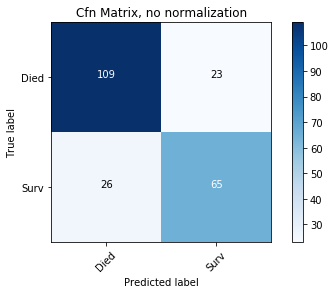

In [121]:
cfn_matrix_features = confusion_matrix(y_test_features, dtc_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

### Random Forest

In [145]:
from math import sqrt

In [155]:
rfc = RandomForestClassifier(n_estimators=1000, max_features=14, max_depth=5, n_jobs=-1)
rfc.fit(X_train_features, y_train_features)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=14, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [156]:
rfc_pred = rfc.predict(X_test_features)

Confusion matrix, without normalization
[[119  13]
 [ 23  68]]


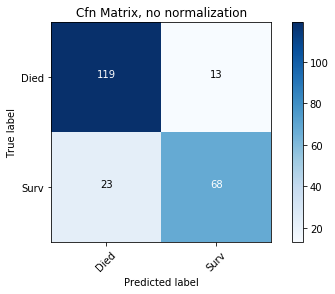

In [157]:
cfn_matrix_features = confusion_matrix(y_test_features, rfc_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

### Run model on test data

In [197]:
df = pd.read_csv("data/test.csv", index_col=0)
# df['Deck'] = df[~df['Cabin'].isnull()]['Cabin'].str[0]
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamSize'] = df['Parch'] + df['SibSp']

decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
title_dummies = pd.get_dummies(df['Title'])
gender_dummies = pd.get_dummies(df['Sex'])
class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')
embarked_dummies = pd.get_dummies(df['Embarked'])
has_age = df['Age'].notnull().astype('int')
has_age.name = 'has_age'

# saving to variables and using .concat() once seems to be much faster
df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies, 
                embarked_dummies, has_age], axis=1)

In [199]:
X_train_age = df[df['Age'].notnull()][df.corr().columns]
X_needs_age = df[df['Age'].isnull()][df.corr().columns]
y_train_age = X_train_age.pop('Age')
X_needs_age = X_needs_age.drop('Age', axis=1)
ridge_age = RidgeCV()

X_train_age['Fare'].fillna(value=X_train_age['Fare'].mean(), inplace=True)

ridge_age.fit(X_train_age, y_train_age)
age_pred = np.array(ridge_age.predict(X_needs_age))

age_pred[age_pred < 0] =0

df.loc[df['Age'].isnull(), ('Age')] = age_pred

In [204]:
X_train_age.describe()

,Pclass,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,...,Rev,female,male,Class_1,Class_2,Class_3,C,Q,S,has_age
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,...,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.0
mean,2.144578,0.481928,0.397590,40.982087,0.879518,0.021084,0.054217,0.105422,0.033133,0.027108,...,0.006024,0.382530,0.617470,0.295181,0.265060,0.439759,0.246988,0.066265,0.686747,1.0
std,0.846283,0.874084,0.810651,61.135998,1.385271,0.143882,0.226787,0.307560,0.179253,0.162645,...,0.077498,0.486739,0.486739,0.456812,0.442031,0.497107,0.431911,0.249120,0.464516,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,0.000000,8.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2.000000,0.000000,0.000000,16.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,3.000000,1.000000,1.000000,41.131365,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,3.000000,8.000000,6.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [205]:
X_train_age['Fare'].mean()

40.98208731117823

In [206]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,...,Rev,female,male,Class_1,Class_2,Class_3,C,Q,S,has_age
count,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.870138,0.447368,0.392344,35.627188,0.839713,0.016746,0.043062,0.083732,0.028708,...,0.004785,0.363636,0.636364,0.255981,0.222488,0.521531,0.244019,0.110048,0.645933,0.794258
std,0.841838,13.139162,0.896760,0.981429,55.907576,1.519072,0.128474,0.203240,0.277317,0.167185,...,0.069088,0.481622,0.481622,0.436934,0.416416,0.500135,0.430019,0.313324,0.478803,0.404727
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,27.461811,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,36.965880,1.000000,0.000000,31.500000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
